In [144]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using CPU


In [145]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
# If we want to normalize data to have zero mean and 1 std, use the following. But we do not do that in barenet.
#train_dataset = datasets.MNIST('./data', train=True, download=True, 
                              #transform=transforms.Normalize((0.1307,), (0.3081,)))
test_dataset = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())

alltrain_loader = DataLoader(dataset=train_dataset, batch_size=train_dataset.data.size()[0], shuffle=False)
for (data, _) in alltrain_loader:    
    print(f'mnist dataset mean={torch.mean(data)}')


batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

mnist dataset mean=0.13066047430038452


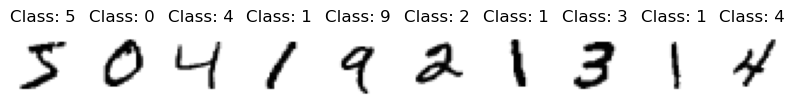

In [146]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))

In [147]:
class TwoLayerMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )
        self.l1 = nn.Linear(28*28, 16)
        #print(f'l1 init weights={self.l1.weight}')
        self.af = nn.ReLU()
        self.l2 = nn.Linear(16, 10)

    def forward(self, x):
        x0 = torch.flatten(x, start_dim=1)
        x1 = self.l1(x0)
        #print(f'x1={x1} weights={self.l1.weight} bias={self.l1.bias}')
        x1_a = self.af(x1)
        x2 = self.l2(x1_a)
        return x2

#Normally, you could just use the following to achieve the same as our manual TwoLayerMLP class.
#nn.Sequential(
#            nn.Flatten(),
#            nn.Linear(28*28, 16),
#            nn.ReLU(),
#            nn.Linear(16, 10)
#        )
model = TwoLayerMLP().to(device)

In [148]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [149]:
# this is the same as the correct(...) function in barenet's train_mlp.cu
# it calculates the number of correct predictions based on the logit values in output
def correct(output, target):
    predicted_digits = output.argmax(1)                            
    correct_ones = (predicted_digits == target).type(torch.float)  
    return correct_ones.sum().item()                               


In [150]:
def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Do a forward pass
        output = model(data)
        #print(f'output={output}')
        # Calculate the loss
        loss = criterion(output, target)
        #print(f'loss={loss}')

        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Training loss: {train_loss:7f}, accuracy: {accuracy:.2%} num_batches: {num_batches}")


In [152]:
%%time

epochs = 50
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, model, criterion, optimizer)

Training epoch: 1
Training loss: 0.242133, accuracy: 93.14% num_batches: 1875
Training epoch: 2
Training loss: 0.236453, accuracy: 93.30% num_batches: 1875
Training epoch: 3
Training loss: 0.231248, accuracy: 93.44% num_batches: 1875
Training epoch: 4
Training loss: 0.226465, accuracy: 93.59% num_batches: 1875
Training epoch: 5
Training loss: 0.221972, accuracy: 93.69% num_batches: 1875
Training epoch: 6
Training loss: 0.217747, accuracy: 93.80% num_batches: 1875
Training epoch: 7
Training loss: 0.213783, accuracy: 93.92% num_batches: 1875
Training epoch: 8
Training loss: 0.210002, accuracy: 94.02% num_batches: 1875
Training epoch: 9
Training loss: 0.206451, accuracy: 94.14% num_batches: 1875
Training epoch: 10
Training loss: 0.203053, accuracy: 94.24% num_batches: 1875
Training epoch: 11
Training loss: 0.199756, accuracy: 94.36% num_batches: 1875
Training epoch: 12
Training loss: 0.196591, accuracy: 94.42% num_batches: 1875
Training epoch: 13
Training loss: 0.193538, accuracy: 94.52% 

In [142]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        #test_loader is constructed such that there is only one batch
        for data, target in test_loader: 
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)

            # Do a forward pass
            output = model(data)

            # Calculate the loss
            loss = criterion(output, target)
            total_loss += loss.item()

            # Count number of correct digits
            total_correct += correct(output, target)
        test_loss = total_loss / num_batches
        accuracy = total_correct/num_items

        print(f"Test loss: {test_loss:>7f} accuracy: {100*accuracy:>0.1f}%")

In [143]:
test(test_loader, model, criterion)

Test loss: 0.248128 accuracy: 92.9%
